# Create Needle In A Haystack Visualization

Let's run through how to create the visualization for the Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Generate a pivot table based on the results
2. Use that pivot table as the basis for Google Slides (or whatever design tool ou want) custom formatting.

See the final [visualization](https://docs.google.com/presentation/d/15JEdEBjm32qBbqeYM6DK6G-3mUJd7FAJu-qEzj8IYLQ/edit?usp=sharing).
See the [overview video](https://twitter.com/GregKamradt/status/1729573848893579488) for this code.

Let's get started. 

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
import os
import glob

The assumption is that your individual test results will be saved to separate files. This is done to make concurrent requests easier.

If that isn't the case, feel free to change up the loading process below. The end result we want is a table with three columns (one row per test)
1. Context Length
2. Document Depth
3. Score Result

Change the folder location for where your results are stored. I'll use the original results folder for this test

## Load Data

In [9]:
model_data = {
    "gemma-2b": {
        "name": "Gemma 2B",
        "path": "../../../needle_in_haystack_results/gemma_2b_results/",
    },
    "gemma-2b-it": {
        "name": "Gemma 2B Instruction Tuned",
        "path": "../../../needle_in_haystack_results/gemma_2b_it_results/",
    },
    "gemma-7b": {
        "name": "Gemma 7B",
        "path": "../../../needle_in_haystack_results/gemma_7b_results/",
    },
    "gemma-7b-it": {
        "name": "Gemma 7B Instruction Tuned",
        "path": "../../../needle_in_haystack_results/gemma_7b_it_results/",
    },
    "llama2": {
        "name": "Llama2 7B",
        "path": "../../../needle_in_haystack_results/llama2_7b_results/",
    },
    "llama2-ft": {
        "name": "Llama2 7B Finetuned",
        "path": "../../../needle_in_haystack_results/llama2_7b_finetuned_results/",
    },
    "phi2": {
        "name": "Phi-2",
        "path": "../../../needle_in_haystack_results/phi2_v1_results/",
    },
    "phi2-ft": {
        "name": "Phi-2 Finetuned",
        "path": "../../../needle_in_haystack_results/phi2_finetuned_results/"
    }
}

model = model_data["gemma-7b-it"]

In [10]:
def df_from_folder(folder):
    # Using glob to find all json files in the directory
    json_files = glob.glob(f"{folder}/*.json")

    # List to hold the data
    data = []

    # Iterating through each file and extract the 3 columns we need
    for file in json_files:
        with open(file, 'r') as f:
            json_data = json.load(f)
            # Extracting the required fields
            document_depth = json_data.get("depth_percent", None)
            context_length = json_data.get("context_length", None)
            score = json_data.get("score", None)
            # Appending to the list
            data.append({
                "Document Depth": document_depth,
                "Context Length": context_length,
                "Score": score
            })

    # Creating a DataFrame
    return pd.DataFrame(data)

df = df_from_folder(model["path"])

print (df[(df["Document Depth"] == 3.0) & (df["Context Length"] <= 1000)])
print (f"You have {len(df)} rows")

      Document Depth  Context Length  Score
7                3.0             955      7
272              3.0             819      9
314              3.0             637      7
477              3.0             546      1
596              3.0             910      7
635              3.0             500      5
639              3.0             773      7
698              3.0             591     10
896              3.0             728      7
973              3.0             682      9
1213             3.0             864      7
You have 1225 rows


In [11]:
a = len(df[df["Score"] < 5.0])
b = len(df[df["Score"] >= 5.0])
print("bad score:", a, "\ngood scores:", b)

bad score: 47 
good scores: 1178


Then let's create a pivot table. If you just ran the test once, then this step isn't needed (but it can be done anyway). If you ran the rest multiple times then this will average out your scores.

## Pivot Data

In [12]:
pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:10, :5]

Context Length,500,546,591,637,682
Document Depth,,,,,
0.0,1.0,7.0,7.0,7.0,7.0
3.0,5.0,1.0,10.0,7.0,9.0
6.0,1.0,1.0,7.0,6.0,1.0
9.0,1.0,9.0,7.0,6.0,7.0
12.0,7.0,1.0,7.0,7.0,7.0
15.0,1.0,6.0,7.0,7.0,7.0
18.0,5.0,9.0,10.0,7.0,10.0
21.0,1.0,10.0,5.0,7.0,7.0
24.0,10.0,7.0,7.0,7.0,10.0


## Make Visualization

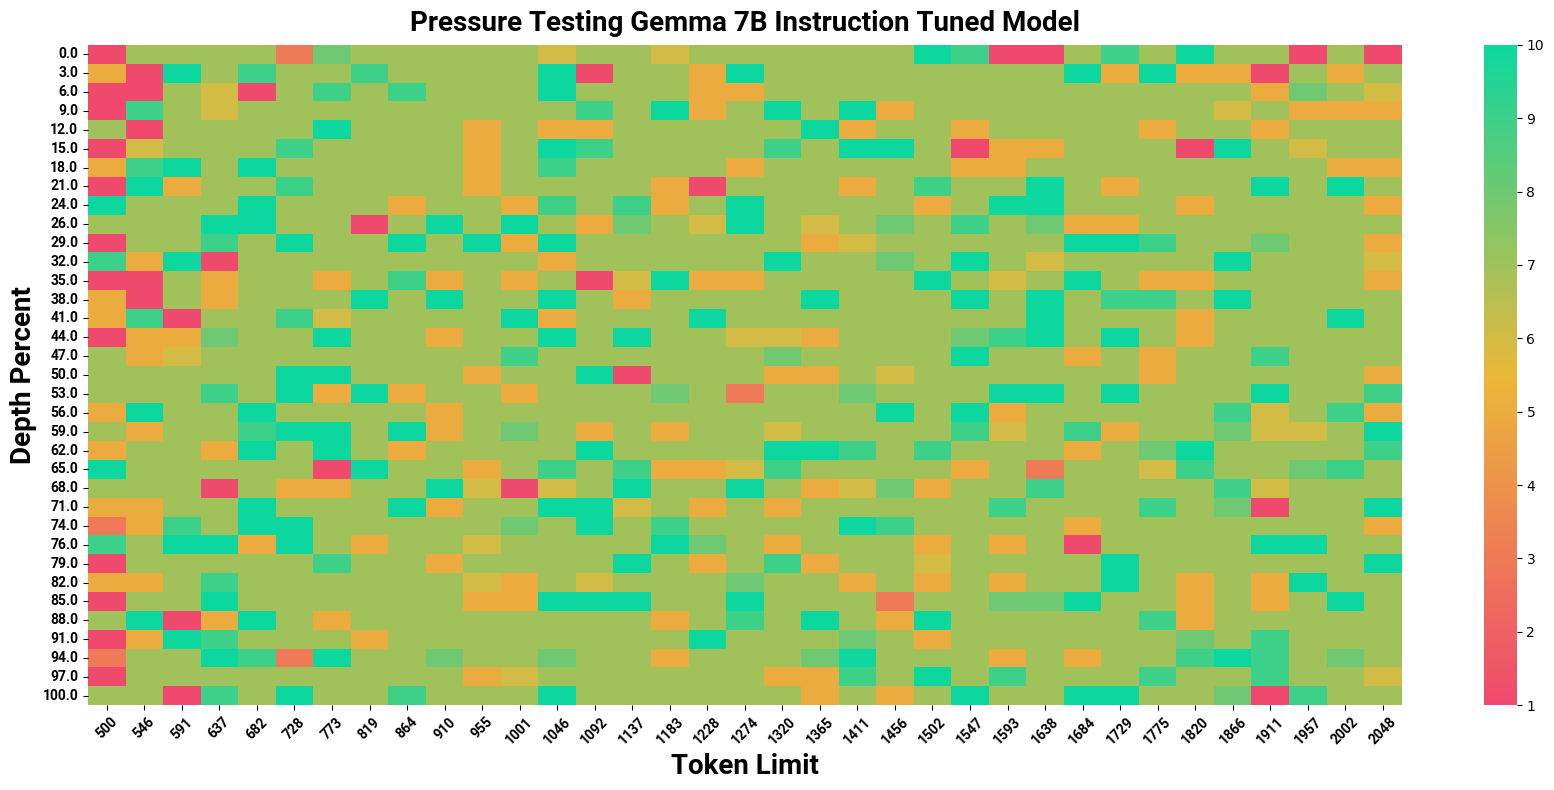

In [13]:
def visualize(data, title, file_name="", save=False):
    pivot_table = pd.pivot_table(data, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
    pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
    pivot_table.iloc[:10, :5]

    # Create a custom colormap. Go to https://coolors.co/ and pick cool colors
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

    # Create the heatmap with better aesthetics
    plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
    sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
    )

    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(
        fname='/usr/share/fonts/truetype/roboto/unhinted/RobotoTTF/Roboto-Bold.ttf',
        size=20,
        weight='bold')
    ticks_font = FontProperties(
        fname='/usr/share/fonts/truetype/roboto/unhinted/RobotoTTF/Roboto-Bold.ttf',
        size=10,
        weight=5)

    # More aesthetics
    plt.title(title, fontproperties=title_font, pad=10)  # Adds a title
    plt.xlabel('Token Limit', fontproperties=title_font)  # X-axis label
    plt.ylabel('Depth Percent', fontproperties=title_font)  # Y-axis label
    plt.xticks(rotation=45, fontproperties=ticks_font)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0, fontproperties=ticks_font)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area

    # Show the plot
    if save:
        plt.savefig(file_name)
    plt.show()
visualize(df, f"Pressure Testing {model['name']} Model")

In [9]:
phi2_finetuned_folder_path = "/home/lazaro/needle_in_haystack_results/phi2_finetuned_results"

In [10]:
phi2_df = df_from_folder(phi2_finetuned_folder_path)
phi2_df

,Document Depth,Context Length,Score
0,65.0,1547,7
1,79.0,500,1
2,6.0,864,1
3,50.0,1502,7
4,26.0,1183,10
...,...,...,...
1220,15.0,1866,10
1221,56.0,1183,3
1222,59.0,1320,10
1223,74.0,637,1


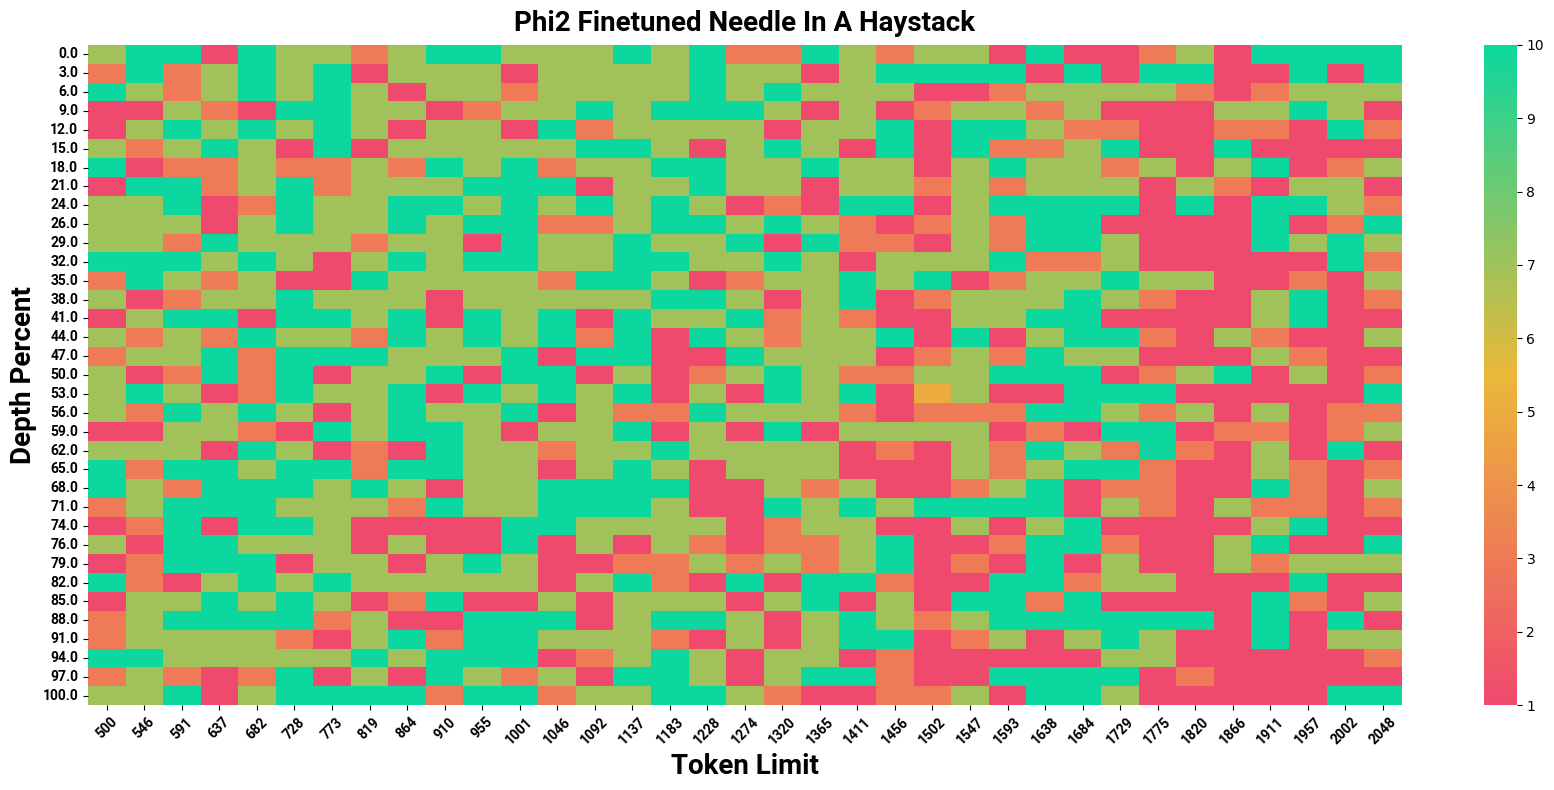

In [11]:
visualize(phi2_df, "Phi2 Finetuned Needle In A Haystack", save=False)

In [12]:
bad_scores_data = phi2_df[phi2_df["Score"] == 1.0]
bad_scores_data.sample(10)

,Document Depth,Context Length,Score
92,3.0,1911,1
347,85.0,1820,1
726,35.0,2002,1
737,21.0,500,1
755,100.0,1411,1
510,97.0,637,1
1001,3.0,1001,1
574,44.0,1593,1
1004,94.0,1957,1
288,50.0,546,1


In [36]:
import sys

sys.path.insert(1, '/home/lazaro/projects/LLMTest_NeedleInAHaystack')

from src.evaluators.openai_evaluator import OpenAIEvaluator
from src.models.huggingface_tester import HuggingFaceTester
from src.llm_needle_haystack_tester import LLMNeedleHaystackTester

In [37]:

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
retrieval_question = "What is the best thing to do in San Francisco?"

evaluator = OpenAIEvaluator("gpt-4-0125-preview", true_answer=needle, question_asked=retrieval_question)

In [38]:
model_name = "cognitivecomputations/dolphin-2_6-phi-2"
prompt = """<|im_start|>system
You are a helpful AI bot that answers questions for a user. Keep your response short and direct.<|im_end|>
<|im_start|>user
{context} Somewhere within the given text lies the answer to the question im am going to ask. Given when you just read, {retrieval_question}<|im_end|>
<|im_start|>assistant"""

model = HuggingFaceTester(model_name, device="auto", prompt_structure=prompt)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
Some weights of the model checkpoint at cognitivecomputations/dolphin-2_6-phi-2 were not used when initializing PhiForCausalLM: ['lm_head.linear.lora_A.default.weight', 'lm_head.linear.lora_B.default.weight']
- This IS expected if you are initializing PhiForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PhiForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
sampled_df = bad_scores_data.sample(10)

depths = sorted(sampled_df["Document Depth"].to_list())
context_lengths = sorted(sampled_df["Context Length"].to_list())

In [40]:
tester = LLMNeedleHaystackTester(model_to_test=model,
                        evaluator=evaluator,
                        needle=needle,
                        retrieval_question=retrieval_question,
                        document_depth_percents=depths,
                        context_lengths=context_lengths)
tester.start_test()



Starting Needle In A Haystack Testing...
- Model: cognitivecomputations/dolphin-2_6-phi-2
- Context Lengths: 10, Min: 682, Max: 1957
- Document Depths: 10, Min: 9.0%, Max: 85.0%
- Needle: The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.





RuntimeError: asyncio.run() cannot be called from a running event loop

In [38]:
import matplotlib.font_manager
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for f in fonts:
    if f[0] == "R":
        print(f)

Rasa
Rekha
Ramabhadra
RaviPrakash
Rachana
RaghuMalayalamSans
Ramaraja
